# **Data Diri**

---
(Peserta Kampus merdeka - Student Indepentdent)


Nama : Gusti Muhammad Aulia Nur Sulthan

Alamat :  Kabupaten Hulu Sungai Selatan, Kalimantan Selatan

SIB Id : M247R6216

SIB Email : M247R6216@dicoding.org	

SIB Group : M3

### Library

In [27]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import tensorflow as tf
from sklearn.utils import class_weight, shuffle
from tensorflow.keras import applications
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense,Conv2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

### Import Dataset from kaggle

In [7]:
! pip install kaggle

In [8]:
! mkdir ~/.kaggle

In [9]:
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets download -d ibrahimserouis99/one-piece-image-classifier

 95% 73.0M/77.2M [00:00<00:00, 104MB/s]
100% 77.2M/77.2M [00:00<00:00, 121MB/s]


In [18]:
# Unzip file
import zipfile
 
zip_ref = zipfile.ZipFile('/content/one-piece-image-classifier.zip','r')
zip_ref.extractall('/content/assets')
zip_ref.close()

In [19]:
os.listdir("/content/assets/Data")

['Zoro', 'Luffy', 'Sanji']

### Load data

In [20]:
foldernames = os.listdir('/content/assets/Data')
categories = []
files = []
for k, folder in enumerate(foldernames):
    filenames = os.listdir("/content/assets/Data/" + folder);
    for file in filenames:
        files.append("/content/assets/Data/" + folder + "/" + file)
        categories.append(k)
        
df = pd.DataFrame({
    'filename': files,
    'category': categories
})
train_df = pd.DataFrame(columns=['filename', 'category'])

In [23]:
for i in range(3):
    train_df = train_df.append(df[df.category == i].iloc[:700,:])

train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

,filename,category
0,/content/assets/Data/Zoro/[0.78761706]inverted...,0
1,/content/assets/Data/Zoro/3.jpg,0
2,/content/assets/Data/Zoro/131.jpg,0
3,/content/assets/Data/Zoro/[0.9094894]inverted.jpg,0
4,/content/assets/Data/Zoro/[0.64581014]inverted...,0
...,...,...
1959,/content/assets/Data/Sanji/Edited13.jpg.jpg,2
1960,/content/assets/Data/Sanji/[0.85949606]inverte...,2
1961,/content/assets/Data/Sanji/[0.61317955]inverte...,2
1962,/content/assets/Data/Sanji/61.jpg,2


In [24]:
train_df.shape

(1964, 2)

In [25]:
! pip install split_folders

In [28]:
x = train_df['filename']
y = train_df['category']

x, y = shuffle(x, y, random_state=8)

## Resize Image

In [30]:
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

images = []
with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):
        #read image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

  0%|          | 0/1964 [00:00<?, ?it/s]

### Split data

In [31]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)
split_val = int(round(0.2*len(y)))
x_train = x[split_val:]
y_train = y[split_val:]
x_test = x[:split_val]
y_test = y[:split_val]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

img_rows, img_cols, img_channel = 224, 224, 3

In [32]:
img_shape=(img_rows, img_cols, img_channel)

### Model Sequential

In [33]:
model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=img_shape),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPool2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

### Parameter fit 

In [44]:
batch_size = 32
epochs = 100

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)

### Callback function

In [35]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.85) and (logs.get('accuracy')>0.85):
      print('\nAkurasi telah mencapai > 85%')
      self.model.stop_training = True
myCallbacks = myCallback()

In [40]:
%load_ext tensorboard

In [41]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [42]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### Train data

In [45]:
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[myCallbacks, tensorboard_callback])

Epoch 1/100
50/50 [==============================] - 245s 5s/step - loss: 0.9026 - accuracy: 0.5805 - val_loss: 0.8026 - val_accuracy: 0.6260
Epoch 2/100
50/50 [==============================] - 246s 5s/step - loss: 0.7741 - accuracy: 0.6785 - val_loss: 0.7412 - val_accuracy: 0.6972
Epoch 3/100
50/50 [==============================] - 254s 5s/step - loss: 0.6545 - accuracy: 0.7301 - val_loss: 0.7208 - val_accuracy: 0.6743
Epoch 4/100
50/50 [==============================] - 254s 5s/step - loss: 0.6092 - accuracy: 0.7632 - val_loss: 0.5262 - val_accuracy: 0.7710
Epoch 5/100
50/50 [==============================] - 254s 5s/step - loss: 0.5142 - accuracy: 0.8027 - val_loss: 0.4394 - val_accuracy: 0.8448
Epoch 6/100
50/50 [==============================] - 253s 5s/step - loss: 0.4614 - accuracy: 0.8358 - val_loss: 0.4554 - val_accuracy: 0.8422
Epoch 7/100
50/50 [==============================] - 245s 5s/step - loss: 0.4260 - accuracy: 0.8421 - val_loss: 0.4760 - val_accuracy: 0.8372
Epoch 

### PLOT MODEL

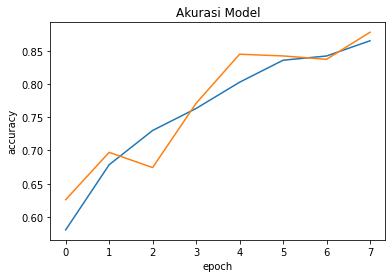

In [52]:
# plot akurasi model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

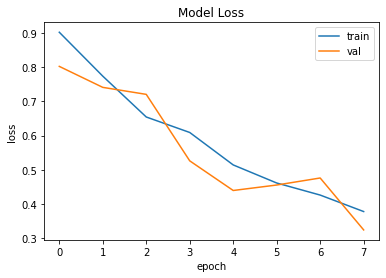

In [53]:
# plot loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.show()

## Convert to TF-life

In [54]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpxvwzsoy_/assets


In [55]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)